<font color="red" size=4>Kaggle competition **Tabular Playground Series - May 2022** final solution kernel</font>
- May 2022 PLayground competition was binary classificationbased on tabular data, 
- My personal goal was to evaluate two implementations of neutal network dedicated to solve tabular data problems
> - the first TabNet implementation was based on Tensorflow framework
> - the second - Torch framework
- I was interested in several aspects of comparison, but especially:
> - the results in comparison with my favourite tools used for this kind of problem 
<br>(one of gradient boosting solutions (XGBoost/LightGBM/CatBoost))
> - the comparison working speed of Tensorflow and Torch implmentation

Theere were train data composed of 900 000 records and test data (700 000).
The features were:
- in some part numerical (float and continuous), 
- in some categorical (with 2 to 16 levels) 
- one more complex feature, 30 of them all over.

The script presents the comparison of classifiers used.

The final conclusion is:
- **On overall, any of tested TabNet implementation performs better than boosters**
- **The price of this performance improvement one must accept to pay**  is much longer time of neural based solution training 

The final score I achieved during the competition was 0.99810 in comparison to 0.99833 winning score (2e-4 higher)

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

- Five classifiers were used:
> - Boosters: XGBoost Classfier, CatBoost Classifier, LGBM Classifier
> - Attentive Interpretable Tabular Learning: TensorFlow and PyTorch implementation

- Each training was performed following the same scenario - 10 folds crossvalidation.
- In case of Tensorflow implementation computation for each fold were repeated and the best model was selected for final scoring
    

# Models results

In [2]:
models_results={
    "TabNet_Tensorflow": "TabNetTensorflow_Results.pkl",
    "TabNet_Torch": "TorchTabNetResults.pkl",
    "XGBoost":"XGBResults.pkl",
    "CatBoost":"CatBoostResults.pkl",
    "LGBM":"LGBMResults.pkl"
}

models_results_={}
for clf,res_filename in models_results.items():
    with open(res_filename,"rb") as f:
        results=pickle.load(f)
    models_results_[clf]={}
    models_results_[clf]['y_val'] = {k:results['folds'][k]['y_val'] for k in results['folds'].keys()}
    models_results_[clf]['y_pred'] = results["folds_val_predictions"]
    # results["folds_val_predictions"] 
validation=pd.DataFrame(models_results_["LGBM"]['y_val'])
validation_data=pd.DataFrame(np.stack(models_results_["LGBM"]['y_val'].values())).T


/home/mchomicz/envs/Kaggle_202205/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# TabNet Tensorflow results - multiple evaluations for fold

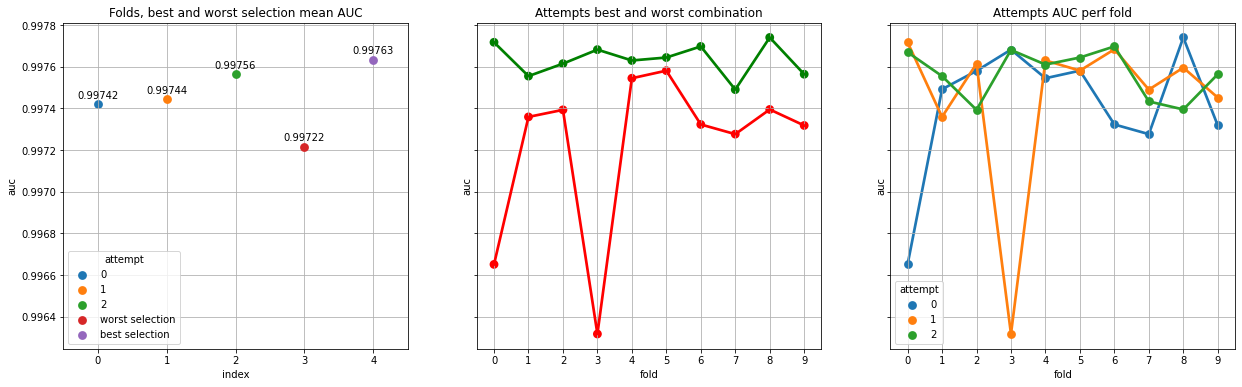

In [3]:
tdf=pd.DataFrame.from_dict({k[0]:models_results_['TabNet_Tensorflow']['y_pred'][k] for k in models_results_['TabNet_Tensorflow']['y_pred']}).T.iloc[:30].T
tdf = tdf.sort_index(axis=1)

# computing auc for folds-attempts
tabnet_tf_scores={}
for c in tdf.columns:
    tabnet_tf_scores[c] = roc_auc_score(validation_data.loc[:, c[0]], tdf[c])
tabnet_tf_scores = pd.DataFrame.from_dict(tabnet_tf_scores, orient='index', columns=['auc']).reset_index()
tabnet_tf_scores['fold']=tabnet_tf_scores['index'].apply(lambda x: x[0])
tabnet_tf_scores['attempt']=tabnet_tf_scores['index'].apply(lambda x: x[1])
del tabnet_tf_scores['index']

# best case per fold
tabnet_tf_scores_max = tabnet_tf_scores.loc[tabnet_tf_scores.groupby('fold').idxmax()['auc']]
tabnet_tf_scores_max.columns=['auc', 'fold', 'attempt']

# worst case per fold
tabnet_tf_scores_min = tabnet_tf_scores.loc[tabnet_tf_scores.groupby('fold').idxmin()['auc']]
tabnet_tf_scores_min.columns=['auc', 'fold', 'attempt']

# mean values
tabnet_tf_mean_scores = tabnet_tf_scores.groupby('attempt').mean()['auc']
tabnet_tf_mean_scores['worst selection'] = tabnet_tf_scores_min.mean()['auc']
tabnet_tf_mean_scores['best selection'] = tabnet_tf_scores_max.mean()['auc']
tabnet_tf_mean_scores = tabnet_tf_mean_scores.reset_index().reset_index()

# plotting
# sns.set_style(style='darkgrid')
fig, ax=plt.subplots(1,3, figsize=(21,6), sharey=True)
sns.pointplot(data=tabnet_tf_scores, x="fold", hue='attempt', y='auc', ax=ax[2])
ax[2].grid('both')
ax[2].set_title('Attempts AUC perf fold')
sns.pointplot(data=tabnet_tf_scores_max, x='fold', y='auc', ax=ax[1], color='green', lebel='best selected')
sns.pointplot(data=tabnet_tf_scores_min, x='fold', y='auc', ax=ax[1], color='red', label='worst selected')
ax[1].grid('both')
ax[1].set_title('Attempts best and worst combination')
sns.pointplot(data=tabnet_tf_mean_scores, x='index', y='auc', hue='attempt', ax=ax[0], linestyles='')
ax[0].grid('both')
ax[0].set_title('Folds, best and worst selection mean AUC');
for _, idx, fold, val in tabnet_tf_mean_scores.itertuples():
    ax[0].text(idx, val+2e-5, f"{val:.5f}", horizontalalignment='center', verticalalignment='bottom')

- For each fold in crossvalidated data 3 attempts were performed
- on validation data the difference between worst selection and best selection is ~4e-4
- In most production systems such a difference would be unimportant, but for competeition it makes a big differece
- attempt 2 is close to best selection, this one is used for further comparison

TabNet_Tensorflow    0.997564
TabNet_Torch         0.997448
CatBoost             0.997202
LGBM                 0.996505
XGBoost              0.996263
dtype: float64


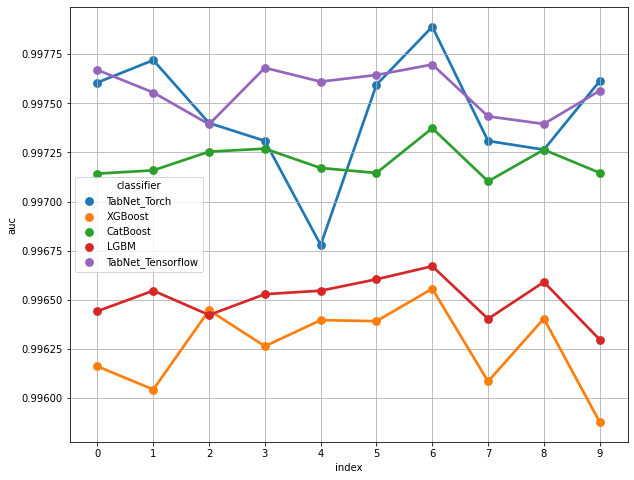

In [24]:
predictions={}
for clf in ["TabNet_Torch", "XGBoost", "CatBoost", "LGBM"]:
    predictions[clf]=pd.DataFrame(models_results_[clf]['y_pred'])
    predictions[clf].columns=[x for x in range(10)]


auc_scores={}
for clf in ["TabNet_Torch", "XGBoost", "CatBoost", "LGBM"]:
    auc_scores[clf]={}
    for c in validation_data.columns:
        auc_scores[clf][c]=(roc_auc_score(validation_data[c], predictions[clf][c]))
auc_scores=pd.DataFrame.from_dict(auc_scores)

# join selected result for tabnet tensorflow
tabnet_tf_res=tabnet_tf_scores.loc[tabnet_tf_scores['attempt']==2].set_index('fold')[['auc']]
tabnet_tf_res.columns=['TabNet_Tensorflow']
auc_scores = auc_scores.join(tabnet_tf_res)

auc_scores_melted=pd.melt(frame=auc_scores.reset_index(), id_vars='index', var_name='classifier', value_name="auc")
fig, ax=plt.subplots(1,1, figsize=(10,8))
sns.pointplot(data=auc_scores_melted, x='index',y='auc', hue='classifier', ax=ax)
ax.grid('both')
print(auc_scores.mean().sort_values(ascending=False))

- On overall TabNet Tensorflow implementation achieved higher score 
- Torch Tabnet implementation has the largest variance (probably longer search for optimal parameters would be beneficial)
- Among three boosters (CatBoost, XGBoost, LightGBM) achieved highest scores (probaby more effort invested in feature selection would be beneficial for boosters)